<a href="https://colab.research.google.com/github/seohyun126/Project/blob/main/UserClustering_%EC%84%9C%ED%98%84_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Recommendation Data + User Info**



In [ ]:
import pandas as pd
rec=pd.read_csv('/content/drive/MyDrive/BOAZ_미니프로젝트1/Code정리/Phase1/result/good_NCF_version2.csv')

In [ ]:
rec.head()

,user_id,test_item,rank,hit_status,final_top10,candidate_size
0,1,1566,295,Miss,"[17, 357, 2396, 1704, 2858, 356, 902, 25, 838,...",761
1,2,1917,33,Miss,"[2716, 1580, 608, 1, 527, 1208, 1377, 912, 150...",731
2,5,1485,230,Miss,"[527, 1673, 2396, 3160, 2336, 3481, 3897, 1639...",730
3,6,597,5,Hit,"[357, 356, 1704, 539, 597, 2671, 902, 1961, 17...",758
4,8,1,34,Miss,"[3578, 3408, 2959, 2997, 3897, 3160, 223, 2706...",729


In [ ]:
import ast

# 문자열 형태의 리스트를 실제 리스트로 변환
rec['final_top10'] = rec['final_top10'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(rec['final_top10'].iloc[0]))
# 리스트로 잘 있는지 확인

<class 'list'>


## **Data for Clustering**


In [ ]:
rec.shape

(4430, 6)

## **Jaccard 유사도를 활용한 K-평균**
- 추천 리스트가 서로 얼마나 겹치는지(집합 유사도)를 기준으로 클러스터링
- J(A,B)=
∣A∪B∣
∣A∩B∣
​

↪ 두 사용자 A와 B의 추천 리스트에서 겹치는 영화 비율이 높을수록 유사도가 높음

↪ 이때의 단점은 사용자의 추천 리스트 순위는 반영이 안된다는 것..!

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Jaccard 유사도 행렬 계산
recommendation_lists = rec['final_top10'].apply(set).tolist()
jaccard_distance_matrix = pairwise_distances(recommendation_lists, metric=lambda x, y: 1 - len(x & y) / len(x | y))

In [ ]:
# 각 사용자별 추천 리스트 기반 distance matrix
jaccard_distance_matrix.shape

(4430, 4430)

Jaccard 거리는 두 집합이 완전히 같으면 0, 완전히 다르면 1

즉, 값이 0에 가까울수록 추천 리스트가 유사, 값이 1에 가까울수록 완전히 다른 추천 리스트 인 것

### **Heatmap으로 jaccard Matrix 그리기**

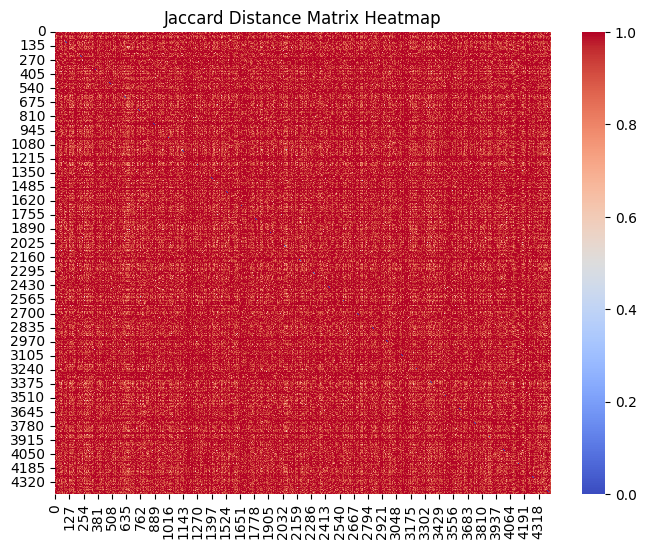

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(jaccard_distance_matrix, cmap="coolwarm", annot=False)
plt.title("Jaccard Distance Matrix Heatmap")
plt.show()

In [ ]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


### **최적의 k 값 찾기**
- elbow method로

0.018497425760517546
0.008676792284284853
0.010129839103754184
0.006738442867026568
0.008104700101787727
0.010153795334689672
0.009616117210698251
0.00962063527522208


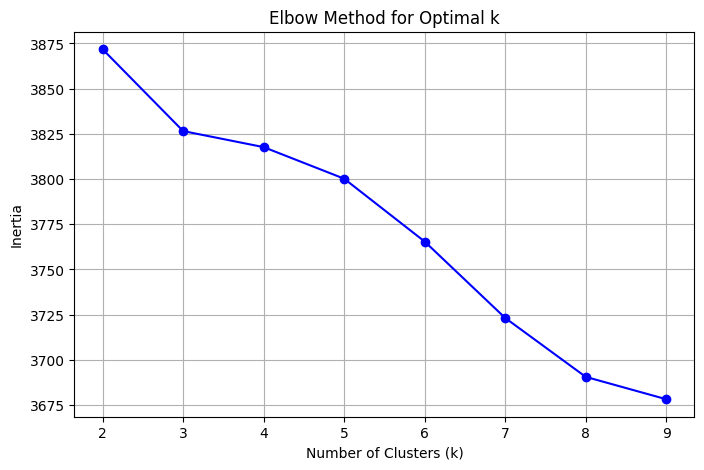

In [ ]:
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
# 최적의 k 찾기: Jaccard 거리 행렬을 사용한 K-Medoids 클러스터링
inertia = []
k_values = range(2, 10)  # k 값을 2~10까지 테스트
silhouette_list=[]

for k in k_values:
    kmedoids = KMedoids(n_clusters=k, metric='precomputed',init='k-medoids++', random_state=42)
    kmedoids.fit(jaccard_distance_matrix)
    inertia.append(kmedoids.inertia_)
    clusters = kmedoids.fit_predict(jaccard_distance_matrix)
    sil=silhouette_score(jaccard_distance_matrix, clusters, metric='precomputed')
    silhouette_list.append(sil)
    print(sil)

# Elbow Method 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()

이때 명확한 k 값은 보이지 않음..

일단 k=5로 잡고 PCA로 결과 시각화

### **시각화하기**


#### PCA로

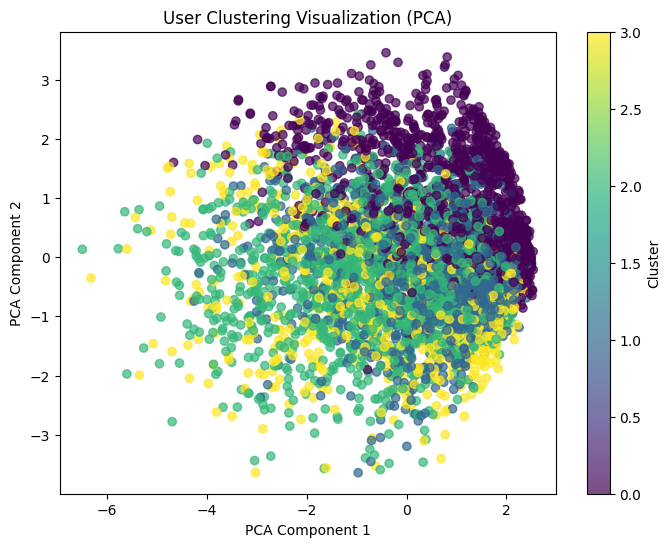

In [ ]:
from sklearn.decomposition import PCA

# Jaccard 거리 행렬을 2D로 축소
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(jaccard_distance_matrix)

# K-Means 클러스터링 실행
k = 4  # 최적의 k 값을 Elbow Method로 결정 후 설정
kmediods = KMedoids(n_clusters=k, metric='precomputed',init='k-medoids++', random_state=42)
clusters = kmediods.fit_predict(jaccard_distance_matrix)

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("User Clustering Visualization (PCA)")
plt.show()

In [ ]:
# Jaccard 거리 행렬을 3D로 축소
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(jaccard_distance_matrix)
# 분산 설명 비율 출력
explained_variance = np.sum(pca.explained_variance_ratio_)
print(explained_variance)

0.28019270665001966


- 애초에 PCA가 데이터를 설명하는 비율이 56%밖에 안됨
- 좀 더 다양한 시각화 -> 비선형 데이터에 유리한

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


#### umap으로

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


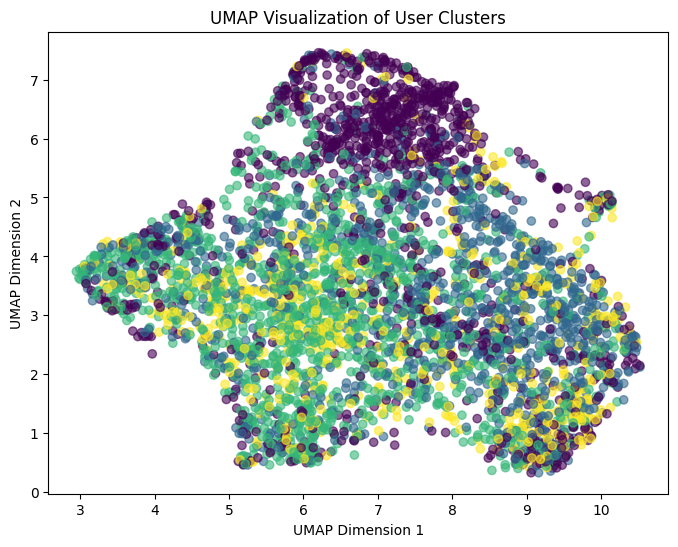

In [ ]:
import umap

# UMAP 변환 (Jaccard Distance Matrix 사용)
umap_model = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
umap_data = umap_model.fit_transform(jaccard_distance_matrix)

# UMAP 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(umap_data[:, 0],umap_data[:, 1],c=clusters, alpha=0.6)
plt.title("UMAP Visualization of User Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [ ]:
from sklearn.manifold import trustworthiness

# Trustworthiness Score 계산
score = trustworthiness(jaccard_distance_matrix, umap_data, n_neighbors=5)
print(f"UMAP Trustworthiness Score: {score:.4f}")

UMAP Trustworthiness Score: 0.8462


#### TSNE로

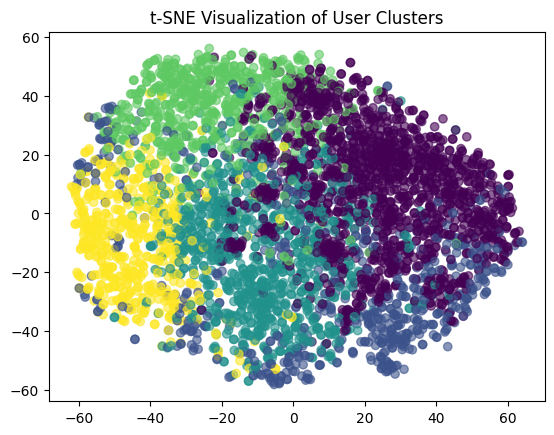

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 변환 (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(jaccard_distance_matrix)

# 시각화
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6, c=clusters)
plt.title("t-SNE Visualization of User Clusters")
plt.show()

In [ ]:
from sklearn.manifold import trustworthiness

# Trustworthiness Score 계산
score = trustworthiness(jaccard_distance_matrix, tsne_data, n_neighbors=5)
print(f"t-SNE Trustworthiness Score: {score:.4f}")

t-SNE Trustworthiness Score: 0.9747


시각화 결과를 보면 나쁘지 않음

일단 그럼 이 열을 추가한 다음 각 cluster에서 대표 뽑아보기

In [ ]:
data['jac_cluster']=clusters

In [ ]:
data.head()

,user_id,final_recommendations,age,job,male,jac_cluster
0,15,"[527, 1198, 2028, 3578, 153, 110, 85, 750, 134...",25,7,1.0,0
1,17,"[1193, 750, 1198, 904, 541, 608, 1204, 1136, 9...",50,1,1.0,1
2,19,"[1198, 669, 527, 1701, 1580, 372, 150, 2858, 1...",15,10,1.0,0
3,22,"[1089, 1193, 2858, 296, 1136, 1208, 2329, 3421...",18,15,1.0,0
4,33,"[1198, 3578, 2028, 527, 480, 2340, 356, 2940, ...",45,3,1.0,0


In [ ]:
jaccard_distance_matrix.shape

(563, 563)

## **AutoEncoder + KMeans Clustering**

[참고]
- https://medium.com/@tschechd/deep-auto-encoders-for-clustering-understanding-and-implementing-in-pytorch-8cc748a5fa48

### **원핫 인코딩**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans

# 데이터 준비 (Binary Encoding: One-hot Encoding of Items)
unique_items = sorted(set.union(*rec['final_top10'].apply(set)))
item_to_index = {item: idx for idx, item in enumerate(unique_items)}

# 각 사용자의 추천 리스트를 One-hot Encoding으로 변환
def encode_list(lst):
    encoded = np.zeros(len(unique_items))
    for item in lst:
        encoded[item_to_index[item]] = 1
    return encoded

X = np.array([encode_list(lst) for lst in rec['final_top10']])

In [ ]:
X.shape

(4430, 510)

In [ ]:
# PCA로 적절한 차원 확인
pca = PCA(n_components=0.95)  # 설명력 95%까지 유지하는 차원
X_pca = pca.fit_transform(X)
optimal_dim = X_pca.shape[1]

In [ ]:
optimal_dim

236

### **Encoder 모델 만들기**

In [ ]:
# Autoencoder 모델 구축
input_dim = X.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation="relu")(input_layer)

encoded = Dense(128, activation="relu")(encoded)

encoded = Dense(128, activation="relu")(encoded)  # 최종 압축

decoded = Dense(128, activation="relu")(encoded)
decoded = Dense(256, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.fit(X, X, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2571
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0781
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0704
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0557
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0485
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0428
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0368
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0321
Epoch 9/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0284
Epoch 10/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0258
Epoch 11/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0228
Epoch 12/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0206
Epoch 13/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0183
Epoch 14/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0164
Epoch 15/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/ste

In [ ]:
# 학습된 임베딩 추출 후 K-Means 클러스터링
user_embeddings = encoder.predict(X)

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
silhouette_score(user_embeddings,labels)

0.04848064

In [ ]:
user_embeddings.shape

(4430, 128)

### **최적의 k 값 찾기**

2 :: 0.07576432
3 :: 0.07099134
4 :: 0.06050402
5 :: 0.05476203
6 :: 0.0588531
7 :: 0.055925768
8 :: 0.05458535
9 :: 0.05358784


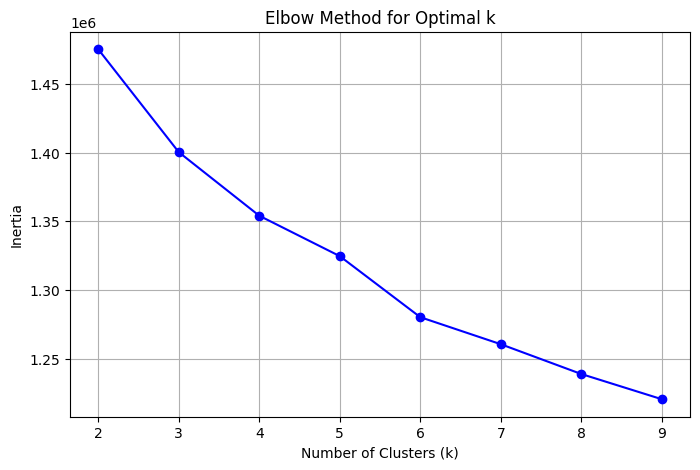

In [ ]:
inertia = []
k_values = range(2, 10)  # k 값을 2~10까지 테스트
silhouette_list=[]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_embeddings)
    inertia.append(kmeans.inertia_)
    labels = kmeans.fit_predict(user_embeddings)
    sil=silhouette_score(user_embeddings, labels)
    silhouette_list.append(sil)
    print(k, '::', sil)

# Elbow Method 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()

[결과]
실루엣 스코어 자체가 잘 안나옴..

## **VAE**
-  VAE에서 이미지를 재생성하듯, 사용자-아이템 데이터를 재생성, 그 과정에서 추출한 latent z를 클러스터링에 활용

In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# VAE 샘플링 레이어
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], encoding_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Encoder 정의
input_layer = Input(shape=(input_dim,))
x = Dense(256, activation='sigmoid')(input_layer)
x = Dense(128, activation='sigmoid')(x)

z_mean = Dense(encoding_dim)(x)
z_log_var = Dense(encoding_dim)(x)
z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])

# Decoder 정의
x = Dense(128, activation='sigmoid')(z)
x = Dense(256, activation='sigmoid')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

vae = Model(input_layer, decoded)
encoder = Model(input_layer, z_mean)  # Variational Embedding

vae.compile(optimizer='adam', loss="binary_crossentropy")
vae.fit(X, X, epochs=100, batch_size=32, verbose=0)

In [ ]:
# 학습된 임베딩 추출 후 K-Means 적용
user_embeddings = encoder.predict(X)
labels = KMeans(n_clusters=3, random_state=42).fit_predict(user_embeddings)

# Silhouette Score 확인
sil_score = silhouette_score(user_embeddings, labels)
print(f"Silhouette Score (VAE): {sil_score:.4f}")

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Silhouette Score (VAE): 0.1807


### **최적의 k 값 찾기**

2 :: 0.18395644
3 :: 0.18072234
4 :: 0.1743757
5 :: 0.15985504
6 :: 0.16211739
7 :: 0.16593257
8 :: 0.15823217
9 :: 0.15464088


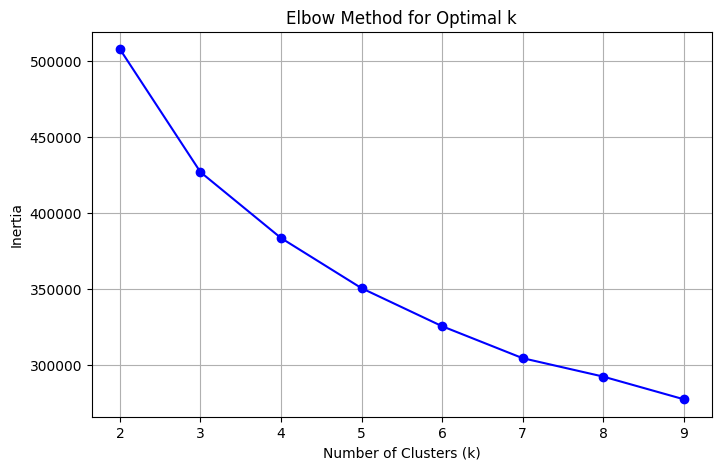

In [ ]:
inertia = []
k_values = range(2, 10)  # k 값을 2~10까지 테스트
silhouette_list=[]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_embeddings)
    inertia.append(kmeans.inertia_)
    labels = kmeans.fit_predict(user_embeddings)
    sil=silhouette_score(user_embeddings, labels)
    silhouette_list.append(sil)
    print(k, '::', sil)

# Elbow Method 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()

실루엣 스코어는 0.18 정도 나옴

In [ ]:
labels = KMeans(n_clusters=7, random_state=42).fit_predict(user_embeddings)

### **tsne로 시각화**

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 변환 (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(user_embeddings)

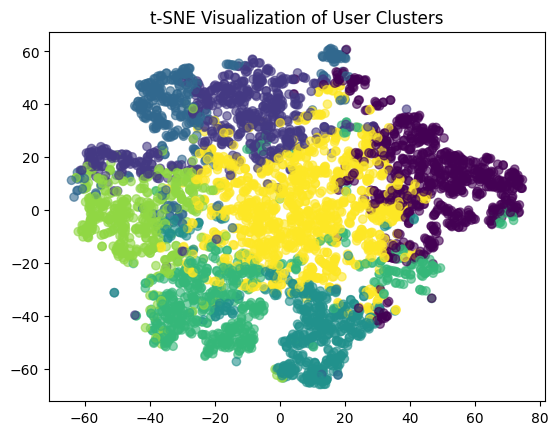

In [ ]:
# 시각화
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6, c=labels)
plt.title("t-SNE Visualization of User Clusters")
plt.show()

In [ ]:
# Trustworthiness Score 계산
score = trustworthiness(jaccard_distance_matrix, tsne_data, n_neighbors=5)
print(f"t-SNE Trustworthiness Score: {score:.4f}")

t-SNE Trustworthiness Score: 0.9378


## **DEC**

### **모델 아키텍처**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.cluster import KMeans

# 2. 오토인코더 정의 및 사전학습 ---------------------------------
def create_autoencoder(input_dim=510, latent_dim=64):
    input_layer = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(input_layer)
    x = layers.Dense(128, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)

    x = layers.Dense(128, activation='relu')(latent)
    x = layers.Dense(256, activation='relu')(x)
    output_layer = layers.Dense(input_dim, activation='sigmoid')(x)

    autoencoder = models.Model(input_layer, output_layer, name='autoencoder')
    encoder = models.Model(input_layer, latent, name='encoder')
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

autoencoder, encoder = create_autoencoder(input_dim=510, latent_dim=64)
autoencoder.fit(X, X, epochs=10, batch_size=256, shuffle=True, validation_split=0.1)

# 3. DEC 모델 정의 (ClusteringLayer) ----------------------------
class ClusteringLayer(layers.Layer):
    def __init__(self, n_clusters, latent_dim, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.alpha = alpha

    def build(self, input_shape):
        self.clusters = self.add_weight(
            name='clusters',
            shape=(self.n_clusters, self.latent_dim),
            initializer='glorot_uniform',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, latent_dim)
        expanded_inputs = K.expand_dims(inputs, axis=1) # (batch_size, 1, latent_dim)
        expanded_clusters = K.expand_dims(self.clusters, axis=0) # (1, n_clusters, latent_dim)
        distances = K.sum(K.square(expanded_inputs - expanded_clusters), axis=2)
        q = 1.0 / (1.0 + distances / self.alpha)
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = q / K.sum(q, axis=1, keepdims=True)  # 정규화
        return q

def create_DEC_model(encoder, n_clusters=6):
    latent_in = encoder.input  # shape=(None, 510)
    latent_out = encoder.output # shape=(None, latent_dim)
    clustering_output = ClusteringLayer(n_clusters, latent_out.shape[-1], name='clustering')(latent_out)
    dec_model = models.Model(inputs=latent_in, outputs=clustering_output, name='DEC_model')
    return dec_model

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.2234 - val_loss: 0.0224
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0202 - val_loss: 0.0196
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0196 - val_loss: 0.0196


In [ ]:
# 3-1. 클러스터 중심 초기화
n_clusters=6
dec_model = create_DEC_model(encoder, n_clusters=n_clusters)
Z = encoder.predict(X)  # 잠재벡터 추출
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
y_pred_init = kmeans.fit_predict(Z)
cluster_centers = kmeans.cluster_centers_
dec_model.get_layer(name='clustering').set_weights([cluster_centers])

# 4. DEC 학습 루프 -----------------------------------------------
batch_size = 256
max_epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

def target_distribution(q):
    weight = q ** 2 / tf.reduce_sum(q, axis=0)
    return (weight / tf.reduce_sum(weight, axis=1, keepdims=True))

dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(buffer_size=len(X)).batch(batch_size)

for epoch in range(max_epochs):
    # 전체 데이터로 q 추론
    q_all = dec_model.predict(X, batch_size=batch_size)
    # p 갱신
    p_all = target_distribution(q_all)

    # 미니배치 학습
    for step, x_batch in enumerate(dataset):
        with tf.GradientTape() as tape:
            q_batch = dec_model(x_batch, training=True)
            # 인덱스 매핑 없이 순서로 가정 (데이터 섞일 수 있으니 실제론 주의 필요)
            start_i = step * batch_size
            end_i   = start_i + x_batch.shape[0]
            p_batch = p_all[start_i:end_i]

            loss = tf.reduce_mean(tf.keras.losses.KLDivergence()(p_batch, q_batch))

        grads = tape.gradient(loss, dec_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, dec_model.trainable_weights))

    print(f"[Epoch {epoch+1}/{max_epochs}] Loss: {loss.numpy():.4f}")

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[Epoch 1/10] Loss: 0.6289
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[Epoch 2/10] Loss: 0.0065
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[Epoch 3/10] Loss: 0.0014
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[Epoch 4/10] Loss: 0.0008
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[Epoch 5/10] Loss: 0.0005
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[Epoch 6/10] Loss: 0.0005
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[Epoch 7/10] Loss: 0.0004
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[Epoch 8/10] Loss: 0.0004
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[Epoch 9/10] Loss: 0.0003
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[Epoch 10/10] Loss: 0.0003


In [ ]:
# 5. 최종 클러스터링 결과 ----------------------------------------
q_final = dec_model.predict(X, batch_size=batch_size)
clusters_assigned = q_final.argmax(axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# 1) 오토인코더 Encoder를 통해 잠재벡터 추출
latent_vec = encoder.predict(X)  # shape: (4430, latent_dim)
print("Latent vector shape:", latent_vec.shape)

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Latent vector shape: (4430, 64)


### **PCA로 시각화**

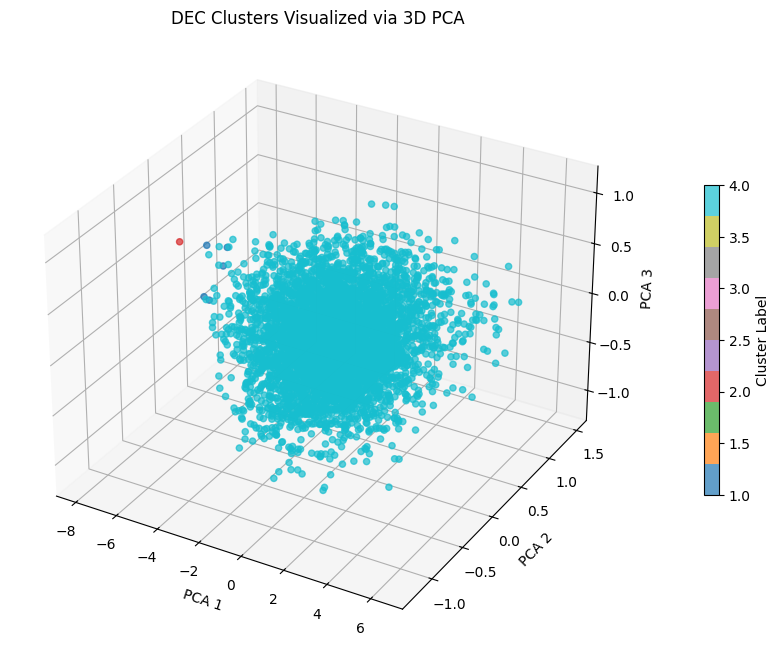

In [ ]:
pca = PCA(n_components=3, random_state=42)
latent_3d = pca.fit_transform(latent_vec)  # shape: (4430, 2)

# 2) 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    latent_3d[:, 0],
    latent_3d[:, 1],
    latent_3d[:, 2],
    c=clusters_assigned,
    cmap='tab10',  # 10개 클러스터 가정 시
    alpha=0.7
)

# 컬러바 추가
cbar = fig.colorbar(scatter, ax=ax, fraction=0.02, pad=0.1)
cbar.set_label('Cluster Label')

# 축/제목 설정
ax.set_title("DEC Clusters Visualized via 3D PCA")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.show()

In [ ]:
# 분산 설명 비율 출력
explained_variance = np.sum(pca.explained_variance_ratio_)
print(explained_variance)

0.78050834


In [ ]:
silhouette_score(latent_vec, clusters_assigned)

0.5466241

In [ ]:
silhouette_score(X, clusters_assigned)

0.012070141521521166

In [ ]:
latent_vec.shape

(4430, 64)

In [ ]:
pca_tsne= PCA(n_components=30, random_state=42)
tsne_pca=pca_tsne.fit_transform(latent_vec)

In [ ]:
np.sum(pca_tsne.explained_variance_ratio_)

0.98747265

In [ ]:
# t-SNE 변환 (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(latent_vec)

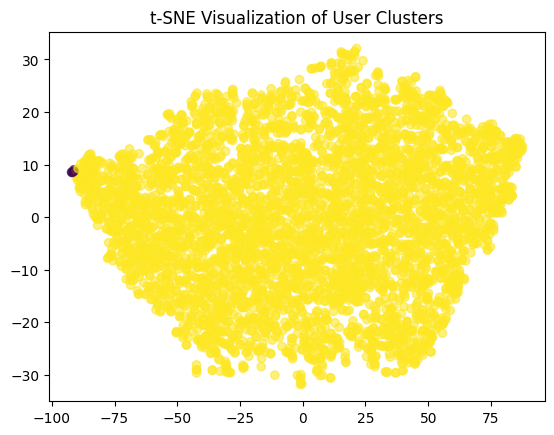

In [ ]:
# 시각화
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6, c=clusters_assigned)
plt.title("t-SNE Visualization of User Clusters")
plt.show()